In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

import seaborn as sns

In [2]:
import matplotlib
# For higher resoltion figures
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Helvetica" #somethings this one doesnt work
plt.rcParams['pdf.fonttype'] = 42

In [3]:
with open("../data/other_TF_data/Ino4_orthologs.fasta", "r") as f:
    lines = f.readlines()

names = []
seqs = []
seq = ""

for line in lines:
    if line.startswith(">"):
        names.append(line.strip().replace(">",""))
        if len(seq) > 0:
            seqs.append(seq)
            seq = ""
    else:
        seq += line.strip()

seqs.append(seq)

seq_df = pd.DataFrame({'Sequence' : seqs,'name' : names}) #.merge(name_key, on="name")


# Make alignment plot

### Run all predictors on sequences to predict activation domains

In [7]:
# Read in ADHunter predicted activities
predictions = pd.read_csv('../data/other_TF_data/Ino4_consensus_predictions.csv', converters={'combined_preds':pd.eval}, index_col=0)

In [8]:
def get_AD(pred_list, aa_seq):
    ADs = []
    AD = ""
    for i, aa in zip(pred_list, aa_seq):
        if i > 0.4:
            AD += aa
        elif len(AD) > 0:
            ADs.append(AD)
            AD = ""
    if len(AD) > 0:
        ADs.append(AD)
    return ADs


In [9]:
merged = predictions.merge(seq_df, on='name')
merged["species"] = ["".join(s.split("_")[1:]) for s in merged["name"]]
merged = merged.drop_duplicates("species")
merged['AD_seqs'] = [get_AD(pred_ls, aa_seq) for pred_ls, aa_seq in zip(merged['combined_preds'], merged["Sequence"])]
merged['final_AD'] = [ls[-1] if len(ls) > 0 else "" for ls in merged['AD_seqs']]

In [10]:
merged['AD_seqs'] 

0                                                      []
3       [QQEFVPDFFPAGTDFDTAFNQFAYDFNVFQPDLSPRFDHAQSPLS...
6                                                      []
7                                                      []
8                                                      []
                              ...                        
1625                                                   []
1626                                                   []
1627                                                   []
1628                                                   []
1631                                                   []
Name: AD_seqs, Length: 1078, dtype: object

In [7]:
# Merge ADHunter predictions with filtered df
with open("../data/other_TF_data/Ino2_orthogroups_AD_regions.fasta", "w+") as f:
    for i in merged.index:
        f.write(">" + merged.loc[i, "name"] + "\n")
        f.write(merged.loc[i, "final_AD"] + "\n")

In [8]:
! mafft --auto "../data/other_TF_data/Ino2_orthogroups_AD_regions.fasta" > "../data/other_TF_data/Ino2_orthogroups_AD_regions_mafft.fasta"

outputhat23=2
treein = 0
compacttree = 0
stacksize: 8176 kb
rescale = 1
All-to-all alignment.
tbfast-pair (aa) Version 7.526
alg=L, model=BLOSUM62, 2.00, -0.10, +0.10, noshift, amax=0.0
0 thread(s)

outputhat23=2
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
  130 / 139
done.

Progressive alignment ... 
STEP    91 /138 
Reallocating..done. *alloclen = 1233
STEP   138 /138 
done.
tbfast (aa) Version 7.526
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
1 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 0
randomseed = 0
blosum 62 / kimura 200
poffset = 0
niter = 2
sueff_global = 0.100000
nadd = 2
Loading 'hat3' ... done.
rescale = 1

  130 / 139
Segment   1/  1    1- 192
done 002-001-1  identical.    identical.    rejected. identical.    rejected. identical.    identical.    rejected. rejected.
dvtditr (aa) Version 7.526
al

In [9]:
# Colors for the alignment conservation plots
amino_acid_colors = {
    # Purples
    'F': '#FFA442',  
    'W': '#006CAF',
    'L': '#5B2B82',
    'Y': '#CBC3E3',
    'M': '#CF9FFF', 

    # Reds
    'D': '#E03839', 
    'E': '#FDA0A5', 

    # Blues
    'K': '#00B3E5',  # Deep sky blue
    'R': '#00B3E5',  # Blue 

    # black
    'S': '#000000',  # Gainsboro
    'P': '#000000',  # Dim grey

    # greys
    'A': '#787878',  # Lime green
    'V': '#787878',  # Light green
    'I': '#787878',  # Sea green
    'T': '#787878',  # Silver
    'G': '#787878',  # Slate grey
    'C': '#787878',  # Burly wood
    'N': '#787878',  # Wheat
    'Q': '#787878',  # Tan
    'H': '#787878',   
    '-': "#FFFFFF"
}

amino_acid_colors = {
    # Purples
    'F': '#FFA442',  
    'W': '#006CAF',
    'L': '#5B2B82',

    # Reds
    'D': '#E03839', 
    'E': '#FDA0A5', 

    # Blues
    'K': '#00B3E5',  # Deep sky blue
    'R': '#00B3E5',  # Blue 

    # black
    'S': '#000000',  # Gainsboro
    'P': '#000000',  # Dim grey

    # greys
    'A': '#787878',  # Lime green
    'V': '#787878',  # Light green
    'I': '#787878',  # Sea green
    'M': '#787878',  # Olive drab
    'T': '#787878',  # Silver
    'G': '#787878',  # Slate grey
    'C': '#787878',  # Burly wood
    'N': '#787878',  # Wheat
    'Q': '#787878',  # Tan
    'H': '#787878',  
    'Y': '#787878', 
    '-': "#FFFFFF"
}


In [10]:
# Code to make alignment conservation plots
def make_alignment_conservation_plot(alignment_file, output_file, remove_gaps=False):
    with open(alignment_file, "r") as f:
        lines = f.readlines()

    names = []
    seqs = []
    seq = ""

    for line in lines:
        if line.startswith(">"):
            names.append(line.strip().replace(">",""))
            if len(seq) > 0:
                seqs.append(seq)
                seq = ""
        else:
            seq += line.strip()

    seqs.append(seq)

    amino_acids = ['H', 'Q','N', 'C', 'G', 'T', 'I', 'V', 'A', 'S',  'P', 'R', 'K', 'D', 'E', 'M', 'Y', 'L', 'W', 'F', '-']
    amino_acids = ['Y', 'H', 'Q','N', 'C', 'G', 'T', 'M', 'I', 'V', 'A', 'S',  'P', 'R', 'K', 'D', 'E', 'L', 'W', 'F', '-']

    # Each sequence position gets an dictionary is the list
    amino_acid_dicts = [{aa: 0 for aa in amino_acids}.copy() for _ in range(len(seqs[0]))]

    for seq in seqs: 
        for i, aa in enumerate(seq): 
            amino_acid_dicts[i][aa] += 1
    
    if remove_gaps: 
        filtered_aa_dict = []
        for aa_d in amino_acid_dicts:
            if aa_d['-'] < len(seqs) * .90:
                filtered_aa_dict.append(aa_d)
        amino_acid_dicts = filtered_aa_dict

    from matplotlib.lines import Line2D
    fig, ax = plt.subplots(figsize=(20,3))

    for i, count_dict in enumerate(amino_acid_dicts): 
        bottom = 0
        for aa, count in count_dict.items():
            p = ax.bar(i, count/len(seqs), label=aa, bottom=bottom, color = amino_acid_colors[aa])
            bottom += count/len(seqs)

    ax.set_xlabel("Alignment position", fontsize=16)
    ax.set_ylabel("Percent of sequences", fontsize=16)

    custom_lines = []

    for color in list(amino_acid_colors.values()):
        custom_lines.append(Line2D([0], [0], color=color, lw=2))

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax.legend(custom_lines, list(amino_acid_colors.keys()), bbox_to_anchor=(1.05, 1.05), fontsize=5.5, frameon=False)
    sns.despine()
    plt.savefig(output_file)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


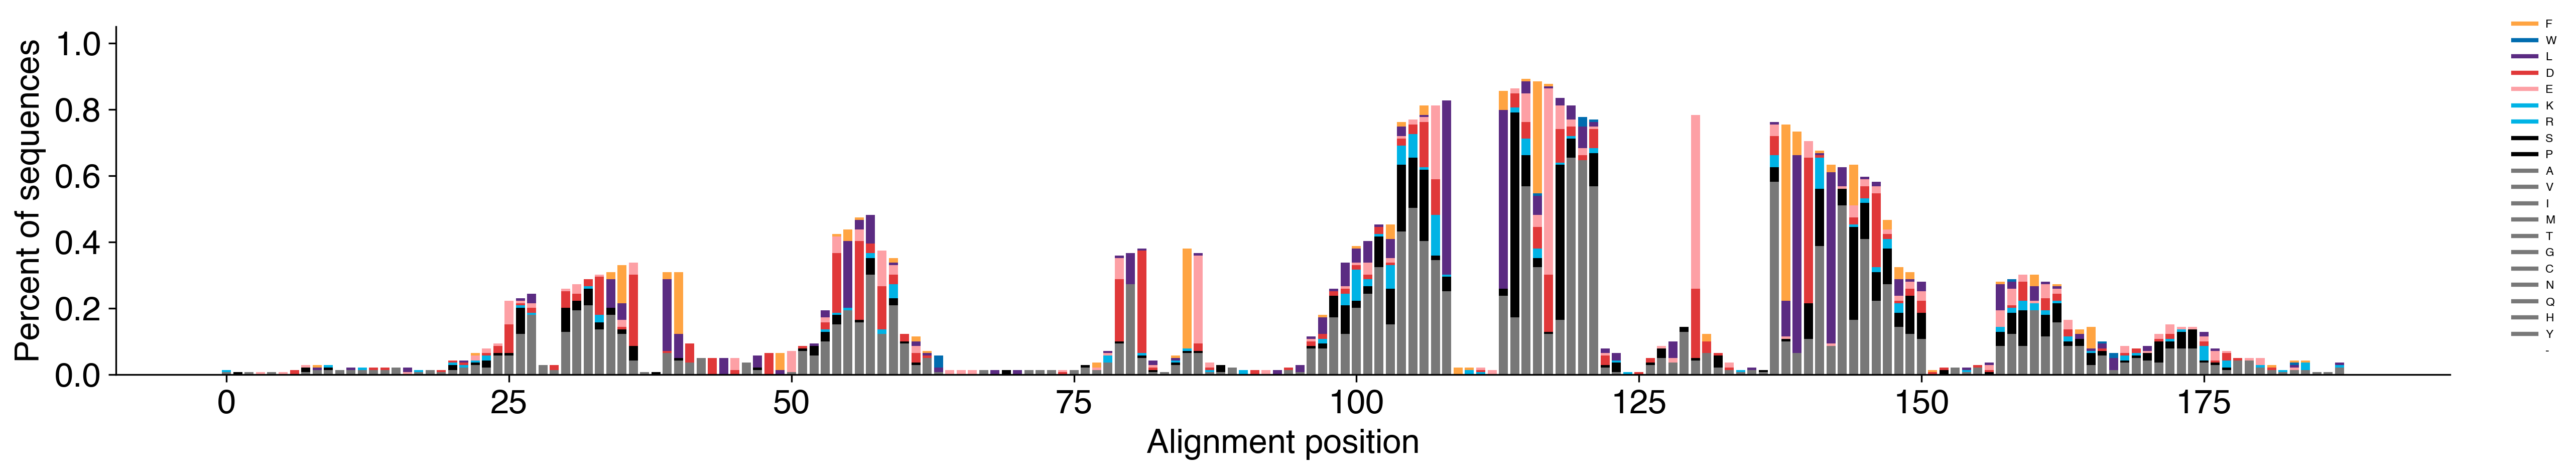

In [11]:
make_alignment_conservation_plot("../data/other_TF_data/Ino2_orthogroups_AD_regions_mafft.fasta", "../figures/Ino2_ADregions_orthogroups_alignment_conservation_plot.pdf")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


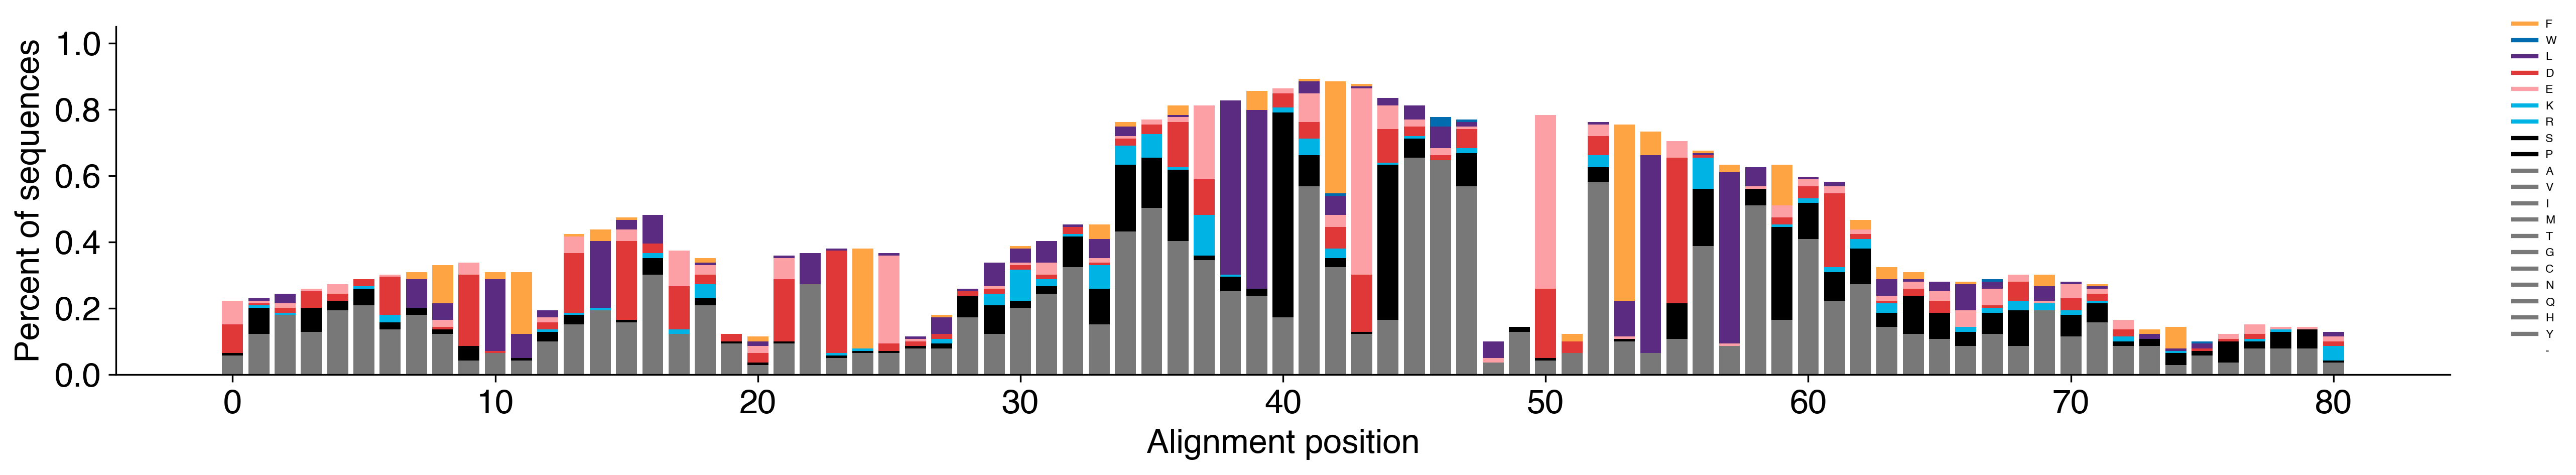

In [14]:
make_alignment_conservation_plot("../data/other_TF_data/Ino2_orthogroups_AD_regions_mafft.fasta", "../figures/Ino2_ADregions_orthogroups_alignment_conservation_plot_no_gaps.pdf", remove_gaps=True)